In [1]:
from utils.hive_access import *
from pyhive import hive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import defaultdict
from unidecode import unidecode
from nlp.preprocessing_portuguese import TextPreProcessing as tpp
import json
import re
from gensim.parsing.preprocessing import strip_multiple_whitespaces
import json
from nlp.preprocessing_v1 import *

In [2]:
df_arquivo = pd.read_csv('../data/output/nota_fiscal_fasttext/f03_items.csv.zip', sep=';')
print('arquivo', df_arquivo.shape[0])
df_arquivo.head()

arquivo 3679117


,palavras,unidades_medida,numeros,cores,materiais,tamanho,quantidade,preco,dsc_unidade_medida,original,original_prep,ano,licitacao,licitacao_item,item_id
0,"['prestacao', 'servico', 'eletrico', 'veiculo'...",[],['2.41e+03'],[],[],[],[],63.00,hora,PRESTACAO DE SERVICOS ELETRICOS EM VEICULOS LE...,"['prestacao', 'servico', 'eletrico', 'veiculo'...",2014,91611180,38706974,0
1,"['oleo', 'diesel', 'combustivel']",[],"['1.00e+01', '2.57e+03']",[],[],[],[],2.71,litro,OLEO DIESEL COMBUSTIVEL S10 2567,"['oleo', 'diesel', 'combustivel', '10', '2567']",2014,91611231,38706975,1
2,"['graxo', 'brif', 'ngl2']",[],"['9.00e+00', '2.80e+03']",[],[],[],[],30.00,unidade,G 052737Q9 GRAXA LUBRIF NGL2 2797,"['g', 'q', '9', 'graxo', 'brif', 'ngl2', '2797']",2014,91638555,38706976,2
3,"['oleo', 'dif']",[],"['9.00e+00', '8.50e+01', '1.40e+02', '2.80e+03']",[],[],[],[],25.00,unidade,G 052815Q9 OLEO DIF 85W140 2798,"['g', 'q', '9', 'oleo', 'dif', '85', 'w', '140...",2014,91638555,38706977,3
4,['pneu'],[],"['1.30e+01', '4.72e+02']",[],[],[],[],180.00,unidade,PNEU 16570R13 472,"['pneu', 'r', '13', '472']",2014,91611257,38706978,4


In [3]:
unidade_medida_canonica = {
    'adesivo':['ades','adesivo','adesivos'],
    'aerossol':['ae','aer','aero','aeros','aerosol','aerossol'],
    'alcool':['al','alco','alcool'],
    'aluno':['alun','aluno','alunos'],
    'amostra':['amostra','amostras'],
    'ampola':['amp','ampl','ampola','ampola_s','ampola_s_s','ampolaampola','ampolas','amprs','amps'],
    'analise':['analise','analises'],
    'aparelho':['apa','aparelho','apr'],
    'apresentacao':['apres','apresent','apresentacao','apresentacoes','aps'],
    'assinatura':['assinatura','assinaturas'],
    'atendimento':['at','atdm','aten','atend','atendam','atendimento'],
    'automovel':['automoveis','automovel'],
    'cilindro':['bala','balas'],
    'balde':['bald','balde','balde_s','baldebalde','baldes'],
    'bandeja':['ban','band','bande''bandeija','bandeja','bandejas','banjeja'],
    'barra':['bar','bara','barr','barra','barra_s','barrabarra','barras'],
    'bobina':['bb','bbina','bbna','bibina','bo','bob','bobi','bobin','bobina','bobina_s','bobinas','bolbinas','bombina','bubina'],
    'bombona':['bobona','bombona','bomblona','bombonas','bomblona','bombo'],
    'bexiga':['bex','bexiga'],
    'bisnaga':['big','binaga','bing','bisnaga','bisnaga_s','bisnagabisnaga','bisnagas','bsn','bsng'],
    'bloco':['blc','blcos','blcs','blo','bloc','bloclo','bloco','blocos','bls','boclo'],
    'blister':['bli','blis','blist','blister','blisteres','blisters','blistr'],
    'boca':['boc','boca','bocas'],
    'bolsa':['bol','bols','bolsa','bolsa_s','bolsas'],
    'bomba':['bomb','bomba','bombas','bombinha'],
    'botijao':['botij','botija','botijao','botijoes','btj','bujao','butijao'],
    'cabeca':['cabeca','cabecas'],
    'caixa':['cx','cx.','cxa','cai','caix','caixa','caixa','caixa_s','caixa_s_s','caixac','caixas','caixasss','caixinha','ciaxa','cx,','cx1','cx100','cx12','cx12x200ml','cx12x750ml','cx24unid','cx24x500g','cx24x500ml','cx30und','cx48','cx50','cx500','cx6','cx6x2000ml','cx75un','cxas','cxc','cxcaixa','cxq','cxs', '000000000000000000000000000000000000000000000caixa'],
    'caloria':['caloria','calorias'],
    'camarina':['camarina','camarinas','camarinha'],
    'caneta':['canet','caneta','canetas'],
    'capsula':['capisula','caps','caps_s','capsla','capsola','capsu','capsul','capsula_s','capsulacpsula','capsulas','capula'],
    'carga':['carga','cargas'],
    'cartao':['cartao','cartaocartao'],
    'cartela':['carte','cartel','cartela','cartelas'],
    'centena':['cen','cent','centena'],
    'centimetro':['cemntimetro','centimento','centimentro','centimentros','centimet','centimetro','centimetros','cm'],
    'centimetro quadrado':['cm2'],
    'centimetro cubico':['cm3'],
    'cesta':['cesta','cestas','cestinha'],
    'chamada':['chamada','chamadas'],
    'cilindro':['cil','cilindro','cilindros'],
    'colecao':['col','coleaao','colec','colecao'],
    'comprimido':['compcomprimido','compri','comprido','comprim','comprimdo','comprimi','comprimida','comprimido','comprimido_s','comprimido_s_s','comprimidos','compromido','comrpimido','cp','comp','comprimido 1 unidade', 'comp.', 'cmp', 'compr','comprimid', 'com', 'cpr', 'capsula', 'cap', '0000000000000000000000000000000000000000comprimido'],
    'concessao':['conc','conce','concessao'],
    'cone':['cone','cones'],
    'conjunto':['conj','conjt','conju','conjulto','conjun','conjunt','conjunto','conjuntoconjunto','conjuntos','conjuto'],
    'construcao':['constr','construcao'],
    'consulta':['consul','consulta','consultas'],
    'copia':['cop','copi','copia','copias'],
    'copo':['copo','copos'],
    'cubo':['cubo','cubos'],
    'dezena':['dezena','dzena','dezenas'],
    'duzia':['daozia','duz','duz,,','duzia','duzia_s','duziac','duzias','dza','dzduzia'],
    'deslocamento':['desl','deslocamento'],
    'diaria':['dia','dia_s','diar','diari','diaria','diariais','diarias','diario','dias','dip'],
    'dose':['dose','dosedose','doses','dosagem','dosagens'],
    'dragea':['dra','drag','drage','dragea','drageas','dragueas'],
    'edicao':['edicao','edicoes'],
    'embalagem':['embal','embala','embalag','embalagaem','embalage','embalagem','embalagens','embelagem','embl'],
    'empreitada':['empreita','empreitada'],
    'envelope':['env','enve','envel','envelo','envelop','envelope','envelope_s','envelopeenvelope','envelopes','envl'],
    'equipamento':['equi','equip','equipamento','equipamentos'],
    'espiga':['espiga','espigas'],
    'estojo':['est','estj','estoj','estojo','estojos','etj','etojo'],
    'evento':['even','event','evento','eventos','eventto'],
    'exame':['ex','exa','exam','exame','exames','exane','exm'],
    'exemplar':['exem','exemplar','exemplares'],
    'fardo':['fard','fard1000','fardinho','fardo','fardo_s','fardo_s_s_s','fardofardo','fardos','fardp','frd','frdo'],
    'fatia':['fatia','fatias'],
    'ficha':['ficha','fichas'],
    'fita':['fita','fitas'],
    'flaconete':['flac','flacon','flaconet','flaconete','flaconetes','flanconete','flc'],
    'folha':['fol','folh','folha','folhafolha','folhas','folheto','flh','flhas','flhs','fls','flsfolhas'],
    'folder':['folder','folders'],
    'forma':['form','forma','formas'],
    'fornecimento':['forn','fornecimento'],
    'frasco':['fr', 'frasco.', 'fras', 'frasco 1 unidade', 'frasco/ampola','frasc','fra','frac','fraco','fracso','franco','frasc0','frasco','frasco,','frasco_s','frascoampola','frascofrasco','frasconete','frascos','frc','frcs','frrasco','frs','frs20','frsc','fsc','fsco','fasco','tfrasco'],
    'frete':['fre','frete'],
    'furo':['furo','furos'],
    'galao':['gal','gal20','gala','galao','galao_s','galaogalao','galaogl','galaos','galco','galoes'],
    'garrafa':['gar','gar2','garafa','garf','garr','garra','garraf','garrafa','garrafao','garrafas','garrafinha','garraga','grf','grfa','grfs'],
    'gota':['got','gota','gotas'],
    'grama':['g','gr','grm','grama','grama_s_s','gramas'],
    'hectare':['hc','hectarae','hectare','hectares'],
    'hora':['hhora','hor','hora','hora_s','horahomem','horas_s','horaservico','horashomem','hra','hras','hr', 'hrs', 'horas'],
    'imovel':['imove','imovel'],
    'injecao':['inj','injecao','injecoes','injet','injetavel'],
    'insercao':['insercao','insercoes'],
    'item':['item','itens'],
    'jogo':['jgjogo','jgo','jo','jog','jogo','jogo_s','jogojg','jogojogo','jogos','jg', 'jgs'],
    'kbps':['kbps'],
    'kcal':['kcal','kc'],
    'kg':['kilo','quilo','quilograma','kilograma','kilos','quilos','quilogramas','kilogramas','quilo.','quilograma_s','kg','kg,','kg_s','kgquilo','kgr','kgs','kgs_s','ki','kil','kilo_','kilo_s','kilogram','kilograma_s','kl','klg','quiilograma','quiilogramas','quil','quiligrama','quilo_s','qulogramas'],
    'km':['km','kilome','kilometragem','kilometro','kilometro_s','kilometros','km_s','kmr','kms','kmexcedente','kmquilometro'],
    'kit':['kit','kit_s','kit_s_s','kitao','kite','kitis','kitkit','kits','kt','ktis','kts'],
    'lanceta':['lance','lanceta','lancetas'],
    'lata':['lat','lata','lata_s','latalata','latao','latas'],
    'licenca':['lic','licenca','licencas'],
    'linha':['linha','linhas'],
    'litro':['litros','ltr','lit','litro.','li','l','lt','lts','liitro','litr','litro','litro1','litro_s','litros_s','litrs','lits','littro','ltlitro','lto','ltro','ltrs'],
    'livro':['livreto','livretos','livro','livros'],
    'locacao':['loc','locaca','locacao','locacao_s','locacoes','locao'],
    'lote':['lot','lote','lotes'],
    'metro':['m','met','metl','metr','metro','metro_s','metros','metros_s','metrs','merto','mtros','mtrs','mts'],
    'metro quadrado':['metro quadrado', 'metros quadrado', 'metros quadrados','m2','m2,','m2,,','m2,,,','m2_','m2_s','m2_s_s','m2d','m2m2','m2o','m2xkm','metro2','metros2','metrosquadrados','mts2'],
    'metro cubico':['metro cubico', 'metros cubico', 'metros cubicos','m3','m3','m33','m3_s','m3k','m3km','m3m3','m3x','m3xk','m3xkm','m3xm','m3xmes','metro3','metro3xkm','met3','metros3','metros63','mts3'],
    'maco':['mac','maco','macomaco','macos'],
    'manutencao':['manutenc','manutencao'],
    'maquina':['maquina','maquinas'],
    'material':['materia','materiais','material'],
    'medicamento':['medicamento','medicamentos'],
    'medicao':['medicao','medicoes'],
    'megabit':['mega','megas','megabit','megabites','megabits','megabyte','megabytes'],
    'mensagem':['mensagem','mensagens'],
    'mes':['men','mens','mensa','mensal','mensalidade','mensalmente','mensl','mes','mes_s','mesal','mese','meses','meses_s'],
    'micrograma':['micrograma','microgramas'],
    'milheiro':['mieiro','mil','mileiro','milhar','milh','milha','milhar','milhe','milhei','milheiro','milheiro_s','milheiros','milher'],
    'miligrama':['mg','miligrama'],
    'mililitro':['ml','mililitro','mililitros','militro','militros','minilitro'],
    'milimetro':['mm','milimetro','milimetros','milimitro'],
    'minuto':['min','minu','minuto','minutos'],
    'milimetro quadrado':['mm2'],
    'modulo':['mod','modulo','modulos'],
    'molho':['moio','moios','mol','mole','moles','molhe','molho','molho_s','molhomolho','molhos'],
    'muda':['muda','mudas'],
    'novelo':['nov','novelo','novelos'],
    'obra':['ob','obr','obra','obras'],
    'outras':['outras','outros'],
    'pacote':['pct','pt','pcte','pacote.','pct.','pacot','paco','paconte','pacotao','pacote','pacote_pct','pacote_s','pacote_s_s','pacotepacote','pacoteq','pacotes','pact','pact_s','pact_s_s','pacte','pactes','pcote','pct,','pctes','pcto','pctpacote','pcts','pocote'],
    'pagina':['pagina','paginas'],
    'par':['par','par_s','pare','pares','pares_s'],
    'parcela':['parc','parce','parcela','parcelado','parcelas'],
    'partida':['part','partida','partidajogo','partidas'],
    'passagem':['passagem','passagens'],
    'pasta':['past','pasta'],
    'pastilha':['pasti','pastilha','pastilhas'],
    'patrimonio':['patrimomnio','patrimonio'],
    'peca':['pca','pcas','pcp','pcpeca','pcs','pec','peca','peca_s','peca_s_s','peca_s_s_s','pecapeca','pecas','pecas_s','pecas_s_s_s','pecca','pe','pc','pc.'],
    'pedaco':['ped','pedac','pedaco','pedacos'],
    'pelicula':['pelicula','peliculas'],
    'pente':['pen','pent','pente','pentes'],
    'percentual':['perc','percental','percentual','pdesconto'],
    'percurso':['percu','percurso'],
    'perfuracao':['perfuracao','perfuracoes'],
    'periodo':['period','periodo'],
    'permissao':['permisao','permissao'],
    'pernoite':['pernoite','pernoites'],
    'pesquisa':['pesquisa','pesquisas'],
    'pessoa':['pesso','pessoa','pessoas'],
    'pino':['pino','pinos'],
    'placa':['pla','plac','placa','placas'],
    'plantao':['plant','plantao','plantoes'],
    'pneu':['pneu','pneus'],
    'pomada':['pom','pomad','pomada','pomadas'],
    'ponto':['pon','pont','ponto','pontos','pto','ptos','pts'],
    'porcao':['porc','porcao','porcoes'],
    'porta':['porta','portas'],
    'pote':['pote','pote,','pote_s','potepote','potes'],
    'prato':['prato','pratos'],
    'predio':['predi','predio'],
    'premio':['premi','premiacao','premio'],
    'prestacao':['pres','prest','presta','prestaca','prestacao','prestserv'],
    'procedimento':['procedimento','procedimentos'],
    'produto':['produto','produtos'],
    'projeto':['proj','projet','projeto'],
    'publicacao':['pub','public','publicacao','publicacoes'],
    'quantidade':['qt','qtd','qtde','qu','quant','quantidade'],
    'quilolitro':['quilolit','quilolitro'],
    'quinzenal':['quinzenal','quizenal'],
    'recarga':['rec','recar','recarg','recarga','recarga_s','recargas','recargaund'],
    'refeicao':['ref','refeic','refeicao','refeicoes'],
    'refil':['refil','refil_s','refis'],
    'resma':['res','resma','resmaresma'],
    'retros':['retros','retroz'],
    'rolo':['rol','rolo','rolo_s','rolor','rolorolo','rolos','rlo','rlos','rlrolo','rls'],
    'saco':['sc', 'sacos','sac','saca','sacaria','sacas','saco','saco_s','sacola','sacolas','saqueta','saquinho','saquinhos','scsaco'],
    'sache':['sach','sache','sache07gr','sache_s','saches','sachesache','sachet','sashe','sanche'],
    'segundos':['seg','segundos'],
    'semana':['semana','semanal'],
    'seringa':['seri','serin','sering','seringa','seringa_s','seringas','seringaseringa'],
    'servico':['serico','serivc','serivco','serivcos','serv','serv,','serv3','serv36','servc','servco','servdia','servfuneral','servgico','servi','serviao','serviaos','servic','servici','servico','servico_s','servicoi','servicoo','servicos','servicos_s','servidores','servio','serviso','sev','sevico','srv','srvc','srvico','srvs'],
    'sessao':['ses','sessa','sessao','sessoes'],
    'solucao':['sol','solinj','solinjent','solinjet','solna','soloftalmica'],
    'supositorio':['sup','suposi','supositori','supositorio','supositorios'],
    'suspensao':['sus','susp','suspe','suspen','suspensao'],
    'tabela':['tabel','tabela'],
    'tablete':['tablet','tablete','tabletes'],
    'tabuleiro':['tabul','tabulei','tabuleiro'],
    'talao':['talao','talhao','taloes'],
    'tambor':['tamb','tambo','tambor','tambores','tmb','tmbor'],
    'tenda':['tenda','tendas'],
    'teste':['teste','testes'],
    'tira':['tira','tiras'],
    'tiragem':['tiragem','tiragens'],
    'tonelada':['ton','tonel','tonela','tonelad','tonelada','tonelada_s','toneladas','toneladaxkilometro','toneladaxkm','tontoneladas','tonxkm'],
    'transporte':['trans','transporte','trasp'],
    'tubo':['tub','tube','tubete','tubetes','tubo','tubo_s','tubos','tubotb','tudo','tbtubo','turbo'],
    'unidade':['inid','inidade','nid','nidade','ubd','ubid','ubnid','uid','uidade','uiid','uin','uind','uindade','uinid','uinidade','ujn','ujnd','umi','umid','un,','un,16','un0','un10','un3','un4','un443','un6','un8','un_','un__','un_s','una','unal','unb','unc','und12','und146','und18','und19','und24','und29','und3','und33','und36','und63','und80','unda','undade','unde','undf','undi','undia','undiade','undidade','undma','undq','unds','une','uniadade','uniadde','uniade','unid,','unid18ml','unid29','unid3','unid4','unid54','unid56','unid73','unid94','unid_','unid__','unid_s','unidad3e','unidadade','unidadae','unidadde','unidade','unidade,','unidade1','unidade2','unidade3','unidade_s2','unidade_s_s','unidade_s_s_s','unidadedia','unidadel','unidadeq','unidades','unidae','unidaede','unidd','uniddade','uniddae','unidde','uniddia','unide','unidede','unidf','unidia','unidiade','unidj','unidnid','unig','uniid','uniidade','uniidades','unind','unindade','uniod','unis','unit','unj','unnd','unnid','uno','unod','unt','untario','uund','uunid','uunidade','uynid','unic','unica','unico','un','unid','und','uni','unidad','unid.','unitario','unidade.','un.','uni.','und.','unida','unita','und,','un1','unid..','um','u','unidade(s)','unidade_s','unidade _s', 'unids', 'un', 'unid', 'und', 'uni', 'unidad', 'unid.', 'unitario', 'unidade.', 'un.', 'uni.', 'und.', 'unida', 'unita', 'und,', 'un1', 'unid..', 'um', '0000000000000000000000000000000000000000000unidade', 'u', 'unidade(s)', 'unidade_s', 'unidade _s', 'unids'],
    'vaga':['vaga','vagas'],
    'vara':['vra','vara','varas'],
    'vasilhame':['vasilh','vasilhame'],
    'vaso':['vaso','vasos'],
    'verba':['ver','verba','vbverba'],
    'vidro':['vdr','vdro','vdros','vds','vds,','vdvidro','vidr','vidro','vidros'],
    'veiculo':['vei','veic','veiculacao','veiculo','veiculos'],
    'vergalhao':['verg','vergalhao'],
    'viagem':['vig', 'via','viag','viage','viagem','viagens'],
    'visita':['visit','visita','visitachamado'],
    'volume':['vol','volume']
}

In [4]:
jfile =  open('../data/palavras/right_words_nilc.json', "r")
right_word = json.load(jfile)
jfile.close()

canonical_form = get_canonical_words()
stopwords = get_stopwords()

In [5]:
def isfloat(value):
    value_ = value.replace(',','.')  
    try:
        float(value_)
        return True
    except ValueError:
        return False

def remove_prefix(text, prefix):
    return text[text.startswith(prefix) and len(prefix):]

def remove_special_characters(text):
    lista = '-#@%?º°ª:/;~^`[{]}\\|!$"\'&*()=+><\t\r\n…'
    result = text
    for i in range(0, len(lista)):
        result = result.replace(lista[i], ' ')
    return result

def remove_dots(text):
    lista = '.'
    result = text
    for i in range(0, len(lista)):
        result = result.replace(lista[i], '')
    return result

def forma_canonica_unidade_medida(text):
    for key in unidade_medida_canonica.keys():
        if text in unidade_medida_canonica[key]:
            return key
    return text

def process_un_medida(un_medida):
    un_medida_process = str(un_medida).lower()
    
    if len(un_medida_process) == 50:
        un_medida_process = un_medida_process.lstrip('0')
    un_medida_process = remove_prefix(un_medida_process, "1 ")
    un_medida_process = tpp.remove_accents(un_medida_process)

    un_medida_process = remove_special_characters(un_medida_process)
    un_medida_process = remove_dots(un_medida_process)
    
    un_medida_process = ' '+un_medida_process+' '
    un_medida_process = re.sub(r' (\d+)([a-z]+) ', r' \1 \2 ', un_medida_process, flags=re.I)
    un_medida_process = un_medida_process.strip()

    items = un_medida_process.split(' ')
    new_items = []
    for item in items:
        #if not (not isfloat(item) and has_numbers(item)) and item not in stopwords:
        if item not in stopwords:
            new_items.append(item)
    items = new_items
    
    
    #items = spellcheck_document(items, right_word)
    items = lemmatization_document(items, canonical_form)
    new_items = []
    for item in items:
        new_items.append(forma_canonica_unidade_medida(item))
    
    un_medida_process = ' '.join(new_items)
    
    un_medida_process = strip_multiple_whitespaces(un_medida_process)
    
    return un_medida_process

In [6]:
df_druid = pd.read_csv('../data/dataset_item_notafiscal.csv', sep=';')
print('arquivo', df_druid.shape[0])
df_druid.head()


arquivo 3679298


,seq_nota_fiscal,seq_item_nota,nom_item,dsc_unidade_medida,vlr_unitario_homologado,ano_exercicio
0,91611180,38706974,PRESTACAO DE SERVICOS ELETRICOS EM VEICULOS LE...,HRS,63.00,2014
1,91611231,38706975,OLEO DIESEL COMBUSTIVEL S10 2567,LTR,2.71,2014
2,91638555,38706976,G 052737Q9 GRAXA LUBRIF NGL2 2797,UN,30.00,2014
3,91638555,38706977,G 052815Q9 OLEO DIF 85W140 2798,UN,25.00,2014
4,91611257,38706978,PNEU 16570R13 472,UN,180.00,2014


In [7]:
token = 'LTR'
df_druid_process = df_druid
print(df_druid_process[df_druid_process['dsc_unidade_medida']==token].shape[0])
df=df_druid_process[df_druid_process['dsc_unidade_medida']==token]
for idx,row in df.iterrows():
    print(row['nom_item'])
#df[df['nom_item'].str.contains("OXIGENIO")]

3878
OLEO DIESEL COMBUSTIVEL S10 2567
OLEO DIESEL COMBUSTIVEL S10 2567
GASOLINA COMBUSTIVEL COMUM 491
OLEO DIESEL COMBUSTIVEL S10 2567
GASOLINA COMBUSTIVEL COMUM 491
GASOLINA COMBUSTIVEL COMUM 491
GASOLINA COMBUSTIVEL COMUM 491
OLEO DIESEL COMBUSTIVEL S10 2567
GASOLINA COMBUSTIVEL COMUM 491
OLEO DIESEL COMBUSTIVEL S10 2567
OLEO DIESEL COMBUSTIVEL S10 2567
GASOLINA COMBUSTIVEL COMUM 491
OLEO DIESEL COMBUSTIVEL S10 2567
OLEO DIESEL COMBUSTIVEL S10 2567
OLEO DIESEL COMBUSTIVEL S10 2567
OLEO DIESEL COMBUSTIVEL S10 2567
OLEO DIESEL COMBUSTIVEL S10 2567
OLEO DIESEL COMBUSTIVEL S10 2567
OLEO 90 CAIXA 2850
OLEO DIESEL COMBUSTIVEL S10 2567
OLEO DIESEL COMBUSTIVEL S10 2567
OLEO DIESEL COMBUSTIVEL S10 2567
OLEO DIESEL COMBUSTIVEL S10 2567
OLEO DIESEL COMBUSTIVEL S10 2567
OLEO DIESEL COMBUSTIVEL S10 2567
OLEO DIESEL COMBUSTIVEL S10 2567
OLEO DIESEL COMBUSTIVEL S10 2567
OLEO DIESEL COMBUSTIVEL S10 2567
OLEO DIESEL COMBUSTIVEL S10 2567
OLEO DIESEL COMBUSTIVEL S10 2567
OLEO DIESEL COMBUSTIVEL COMUM 4

OLEO DIESEL S 500
GASOLINA COMUM
OLEO DIESEL S 500
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
OLEO DIESEL S 500
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
OLEO DIESEL S 500
OLEO DIESEL S 500
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
OLEO DIESEL S 10
OLEO DIESEL S 10
OLEO DIESEL S 10
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
OLEO DIESEL S 500
OLEO DIESEL S 500
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
OLEO DIESEL S 500
OLEO DIESEL S 500
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
OLEO DIESEL S 500
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
OLEO DIESEL B S 10
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
OLEO DIESEL S 500
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
OLEO DIESEL S 500
GASOLINA COMUM
ETANOL
ET

OLEO DIESEL S 500
GASOLINA COMUM
GASOLINA COMUM
OLEO DIESEL S 500
GASOLINA COMUM
OLEO DIESEL S 500
LEITE PASTEURIZADO TIPO C
GASOLINA COMUM
OLEO DIESEL S 500
GASOLINA COMUM
OLEO DIESEL S 500
OLEO DIESEL S 500
GASOLINA COMUM
GASOLINA COMUM
OLEO DIESEL S 500
OLEO DIESEL S 500
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
OLEO DIESEL S 500
GASOLINA COMUM
OLEO DIESEL S 500
GASOLINA COMUM
OLEO DIESEL S 500
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
OLEO DIESEL S 500
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
OLEO DIESEL S 500
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
OLEO DIESEL S 500
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
OLEO DIESEL S 500
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
OLEO DIESEL S 500
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
GASOLINA COMUM
OLEO DIESEL

In [8]:
df_arquivo_process = df_arquivo.copy() # pd.read_csv('../dados/dataset_item.csv', sep=';')
df_arquivo_process['dsc_unidade_medida_orig'] = df_arquivo_process['dsc_unidade_medida']
df_arquivo_process['dsc_unidade_medida'] = df_arquivo_process.apply(lambda x : process_un_medida(x['dsc_unidade_medida']), axis=1)

In [9]:
df_druid_process = df_druid.copy() # pd.read_csv('../dados/dataset_item_druid.csv', sep=';')
df_druid_process['dsc_unidade_medida_orig'] = df_druid_process['dsc_unidade_medida']
df_druid_process['dsc_unidade_medida'] = df_druid_process.apply(lambda x : process_un_medida(x['dsc_unidade_medida']), axis=1)

In [10]:
def quantidade_unidade_medida_diferentes(df):
    return len(df['dsc_unidade_medida'].unique())
    nuvem(df['dsc_unidade_medida'].values())

In [11]:
def quantidade_itens_sem_unidade(un_medida):
    if (un_medida == None) or (len(str(un_medida).strip()) == 0):
        return 1
    else:
        return 0

In [12]:
def quantidade_unidades_apenas_numeros(un_medida):
    if str(un_medida).isnumeric():
        return 1
    else:
        return 0

In [13]:
def quantidade_tem_numero(un_medida):
    list_number = [
        '0',
        '1',
        '2',
        '3',
        '4',
        '5',
        '6',
        '7',
        '8',
        '9'
    ]
    for number in list_number:
        if number in str(un_medida):
            return 1
    else:
        return 0

In [14]:
def desc_completa_freq(desc_freq, un_medida):
    desc_freq[str(un_medida)] += 1

In [15]:
def tokens_freq(tokens_freq, un_medida):
    tokens = str(un_medida).split(' ')
    for token in tokens:
        tokens_freq[token] += 1

In [16]:
def word_cloud(frequencies, title):
    wordcloud = WordCloud(collocations=False, width=1600, height=800, background_color='white').generate_from_frequencies(frequencies)
    fig, ax = plt.subplots(figsize=(16,8))            
    ax.imshow(wordcloud)
    ax.set_axis_off()
    plt.imshow(wordcloud)
    plt.title(title)
    return wordcloud

In [17]:
def dist_freq(frequencias, title):
    values = np.array(list(frequencias.values()))
    labels = np.unique(values)
    x = list((len(values[values==a]) for a in labels))
    y = list(np.arange(len(labels)))
    fig, ax = plt.subplots(figsize=(8,32))
    ax.barh(y,x)
    y_ticks = np.array(y)
    ax.set_yticks(y[::4])
    ax.set_yticklabels(labels[::4])
    plt.ylim([-1, max(y)+1])
    plt.title(title)
    plt.xlabel('Qtd de unidades de medida')
    plt.ylabel('Qtd de registros')
    plt.show()

#dist_freq(frequencia_desc, 'Unidade medida(completo) mais frequentes')


In [18]:
def desc_completa_char_len(desc_char, un_medida):
    desc_char[len(str(un_medida))] += 1

In [19]:
def desc_completa_str_len(desc_str, un_medida):
    tokens = str(un_medida).split(' ')
    desc_str[len(tokens)] += 1

In [20]:
def dist_freq_len(frequencias, title, xlabel):
    y= list(frequencias.values())
    x= list(frequencias.keys())
    fig, ax = plt.subplots(figsize=(13,8))
    ax.bar(x,y)
    ax.set_xticks(x)
    ax.set_xticklabels(x)
    plt.xlim([-1, max(x)+1])
    plt.xticks(rotation=90, fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Qtd de registros')
    plt.show()

In [21]:
def quantidade_com_preposicao(un_medida):
    list_preposicao = [
        'a',
        'ante',
        'após',
        'até',
        'com',
        'c/'
        'contra',
        'de',
        'desde',
        'em',
        'entre',
        'para',
        'por',
        'perante',
        'sem',
        'sob',
        'sobre',
        'trás',
        'do',
        'da',
        'dum',
        'duma',
        'dele',
        'dela',
        'deste',
        'dessa',
        'daquilo',
        'dali',
        'no',
        'na',
        'num',
        'numa',
        'nele',
        'nela',
        'neste',
        'nessa',
        'naquilo',
        'à',
        'às',
        'ao',
        'aos',
        'àquele',
        'àquilo'
    ]
    tokens = str(un_medida).split(' ')
    for token in tokens:
        if token.lower() in list_preposicao:
            return 1
    else:
        return 0


In [22]:
def quantidade_un_medida_descricao(un_medida, descricao):
    if str(un_medida).lower() in str(descricao).lower():
            return 1
    else:
        return 0


In [23]:
def quantidade_un_medida_descricao_primeira(un_medida, descricao):
    un_medida_p = str(un_medida).lower()
    desc_p = str(descricao).lower()
    if desc_p.find(un_medida_p) == 0:
        return 1
    else:
        return 0

 0.0 %
 2.7179097751799395 %
 5.435819550359879 %
 8.153729325539818 %
 10.871639100719758 %
 13.589548875899697 %
 16.307458651079635 %
 19.025368426259575 %
 21.743278201439516 %
 24.461187976619453 %
 27.179097751799393 %
 29.89700752697933 %
 32.61491730215927 %
 35.33282707733921 %
 38.05073685251915 %
 40.76864662769909 %
 43.48655640287903 %
 46.204466178058965 %
 48.922375953238905 %
 51.640285728418846 %
 54.358195503598786 %
 57.07610527877872 %
 59.79401505395866 %
 62.5119248291386 %
 65.22983460431854 %
 67.94774437949847 %
 70.66565415467842 %
 73.38356392985837 %
 76.1014737050383 %
 78.81938348021824 %
 81.53729325539818 %
 84.25520303057812 %
 86.97311280575806 %
 89.691022580938 %
 92.40893235611793 %
 95.12684213129788 %
 97.84475190647781 %
 quantidade unidade medida diferentes 2688
 quantidade itens sem unidade 849
 quantidade unidades apenas numeros 1187
 quantidade tem numero 156947
 quantidade com preposicao 0
 quantidade un medida na descricao 331050
 quantidad

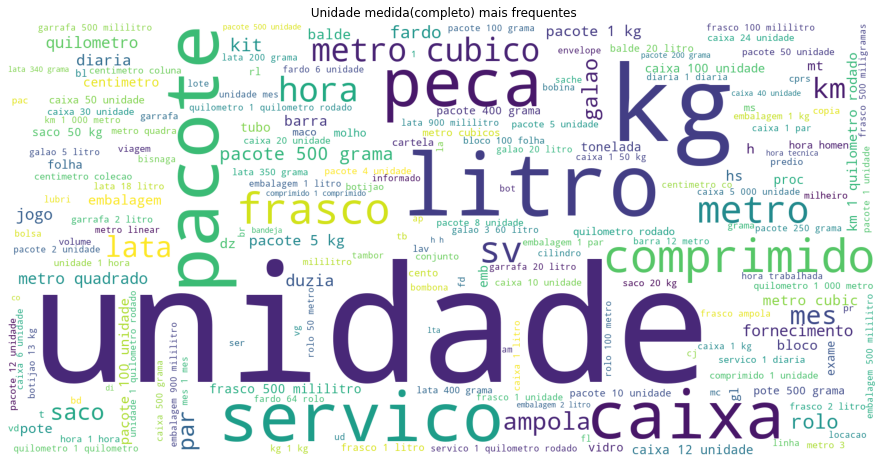

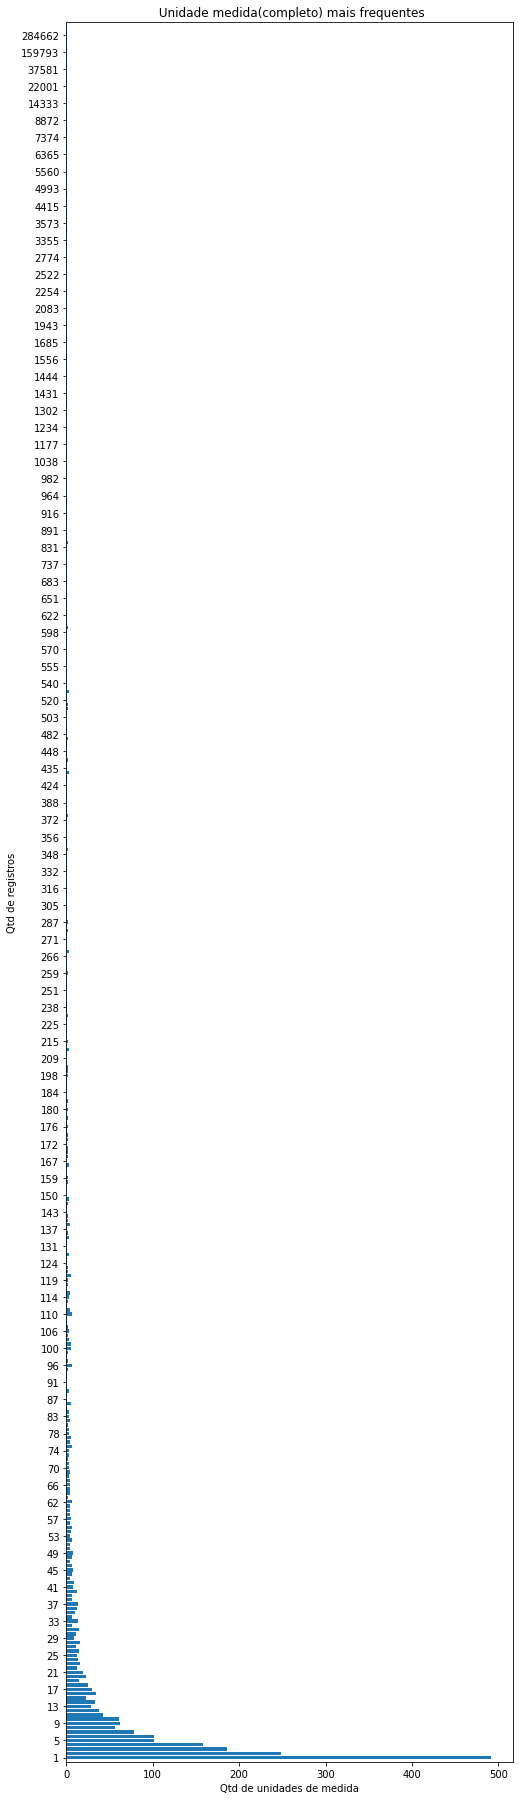

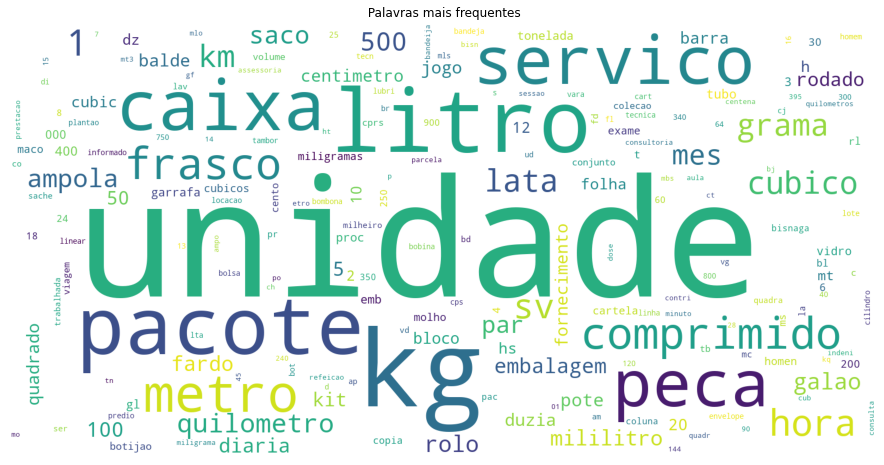

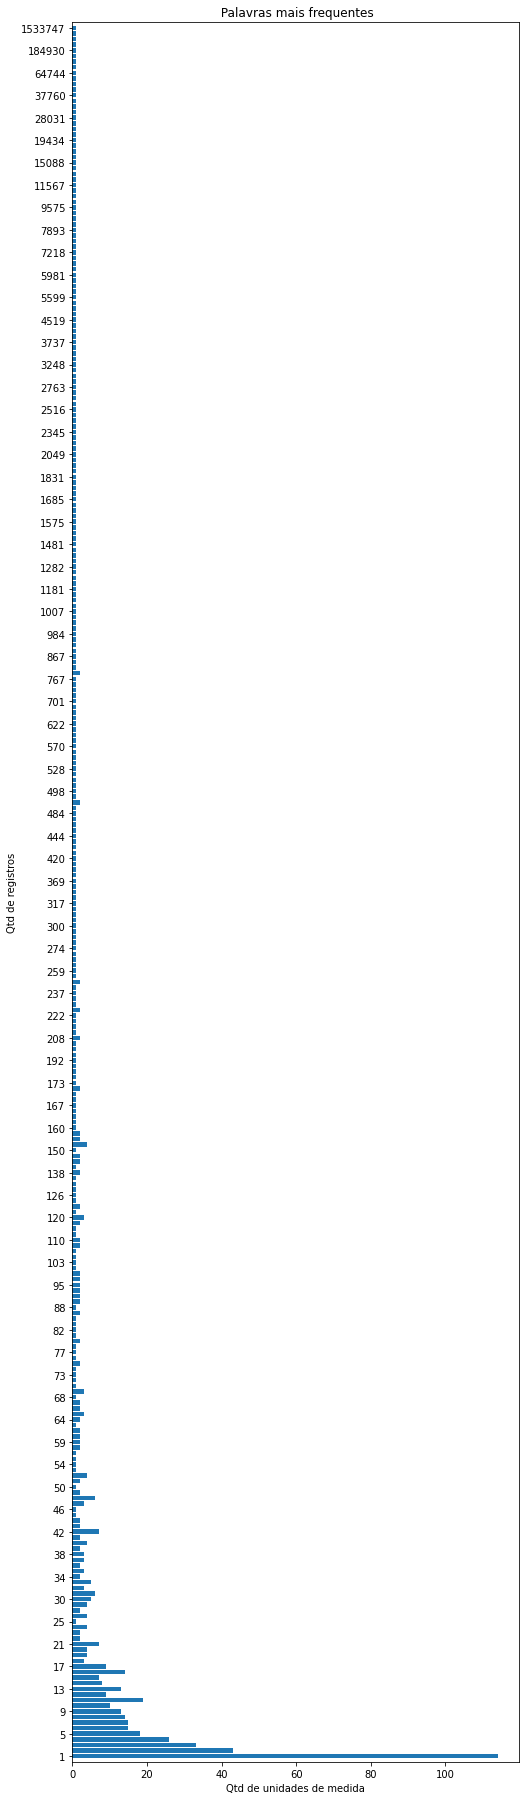

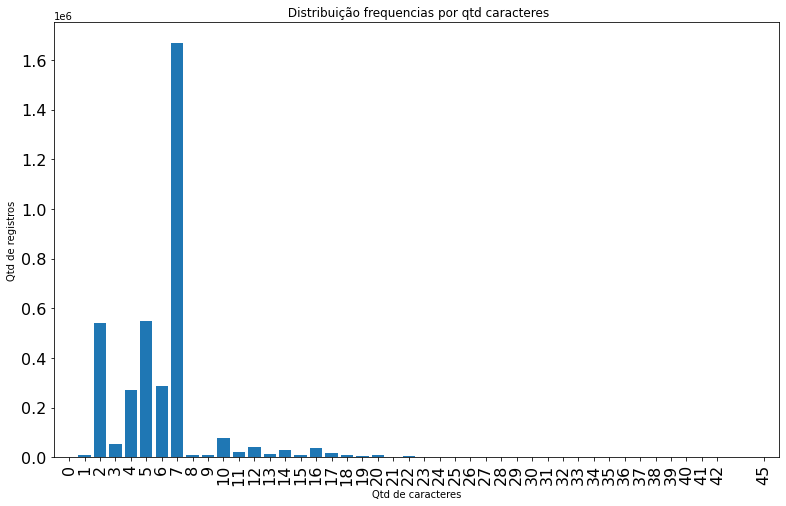

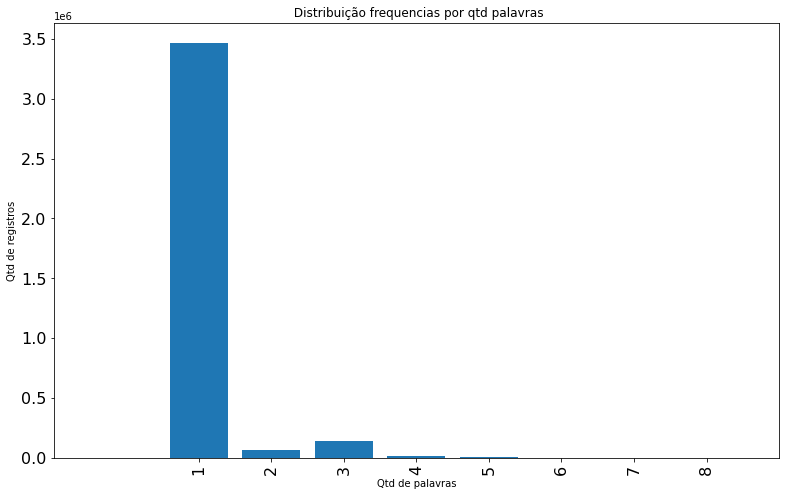

In [24]:
#data_frames=[df_arquivo, df_arquivo_process, df_druid, df_druid_process]
#titles=['Hive+Postgress', 'Hive+Postgress process', 'Druid', 'Druid process']

data_frames=[df_druid_process]
titles=['']
#frequencia_desc = defaultdict(int)
for title, df in zip(titles, data_frames):
    unidade_medida_diferentes = quantidade_unidade_medida_diferentes(df)
    itens_sem_unidade = 0
    itens_apenas_numeros = 0
    tem_numero = 0
    item_com_preposicao = 0
    item_un_medida_descricao = 0
    item_un_medida_descricao_primeira = 0
    frequencia_tokens = defaultdict(int)
    frequencia_desc = defaultdict(int)
    frequencia_desc_char = defaultdict(int)
    frequencia_desc_str = defaultdict(int)
    
    mean_qtd_palavras = 0
    mean_qtd_char = 0

    cont=0
    size = df.shape[0]
    for idx, values in df.iterrows():

        ##Exibir progresso
        if (cont % 100000) == 0:
            print(title, (cont/size)*100, '%')
        cont+=1
        ##


        un_medida = values['dsc_unidade_medida']
        descricao = values['nom_item']
        itens_sem_unidade += quantidade_itens_sem_unidade(un_medida)
        itens_apenas_numeros += quantidade_unidades_apenas_numeros(un_medida)
        tem_numero += quantidade_tem_numero(un_medida)
        desc_completa_freq(frequencia_desc, un_medida)
        tokens_freq(frequencia_tokens, un_medida)
        desc_completa_char_len(frequencia_desc_char, un_medida)
        desc_completa_str_len(frequencia_desc_str, un_medida)
        item_com_preposicao += quantidade_com_preposicao(un_medida)
        item_un_medida_descricao += quantidade_un_medida_descricao(un_medida, descricao)
        item_un_medida_descricao_primeira += quantidade_un_medida_descricao_primeira(un_medida, descricao)

        mean_qtd_palavras += len(str(un_medida).split(' '))
        mean_qtd_char += len(str(un_medida))

        ##Terminar depois de uma amostra, para testar
        #if (cont == 300000):
        #    break
        
    
    mean_qtd_palavras = mean_qtd_palavras/size
    mean_qtd_char = mean_qtd_char/size
    
    print(title, 'quantidade unidade medida diferentes', unidade_medida_diferentes)
    print(title, 'quantidade itens sem unidade', itens_sem_unidade)
    print(title, 'quantidade unidades apenas numeros', itens_apenas_numeros)
    print(title, 'quantidade tem numero', tem_numero)
    print(title, 'quantidade com preposicao', item_com_preposicao)
    print(title, 'quantidade un medida na descricao', item_un_medida_descricao)
    print(title, 'quantidade un medida na descricao primeira posicao', item_un_medida_descricao_primeira)
    print(title, 'media qtd palavras', mean_qtd_palavras)
    print(title, 'media qtd caracteres', mean_qtd_char)
    
    desc_word_cloud = word_cloud(frequencia_desc, title+' Unidade medida(completo) mais frequentes')
    dist_freq(frequencia_desc, title+' Unidade medida(completo) mais frequentes')
    tokens_word_cloud = word_cloud(frequencia_tokens, title+' Palavras mais frequentes')
    dist_freq(frequencia_tokens, title+' Palavras mais frequentes')
    
    dist_freq_len(frequencia_desc_char, title+' Distribuição frequencias por qtd caracteres', 'Qtd de caracteres')
    dist_freq_len(frequencia_desc_str, title+' Distribuição frequencias por qtd palavras', 'Qtd de palavras')

In [25]:
def lista_tem_numero(un_medida, lista):
    list_number = [
        '0',
        '1',
        '2',
        '3',
        '4',
        '5',
        '6',
        '7',
        '8',
        '9'
    ]
    for number in list_number:
        if number in str(un_medida):
            lista.append(str(un_medida))
            break


In [26]:
def lista_multiplas_palavras_diferentes(un_medida, lista):
    if len(str(un_medida).split(' ')) > 1:
        lista.append(un_medida)


In [27]:
def lista_multiplas_palavras_numero_diferentes(un_medida, lista):
    list_number = [
        '0',
        '1',
        '2',
        '3',
        '4',
        '5',
        '6',
        '7',
        '8',
        '9'
    ]
    str_un_medida = str(un_medida)
    if len(str_un_medida.split(' ')) > 1:
        for number in list_number:
            if number in str_un_medida:
                lista.append(str_un_medida)
                break


In [28]:
df=df_druid_process
title='Druid process'

lista_numeros = []
lista_multiplos=[]
lista_numeros_multiplos=[]
frequencia_desc = defaultdict(int)

cont=0
size = df.shape[0]
for idx, values in df.iterrows():

    ##Exibir progresso
    if (cont % 100000) == 0:
        print(title, (cont/size)*100, '%')
    cont+=1
    ##


    un_medida = values['dsc_unidade_medida']
    descricao = values['nom_item']
    
    lista_tem_numero(un_medida, lista_numeros)
    lista_multiplas_palavras_diferentes(un_medida, lista_multiplos)
    lista_multiplas_palavras_numero_diferentes(un_medida, lista_numeros_multiplos)
    
    desc_completa_freq(frequencia_desc, un_medida)
    

    ##Terminar depois de uma amostra, para testar
    #if (cont == 300000):
    #    break


qtd_tem_numeros_diferentes = len(np.unique(lista_numeros))
qtd_multiplos = len(np.unique(lista_multiplos))
qtd_multiplos_numeros = len(np.unique(lista_numeros_multiplos))


print(title, 'quantidade unidade medida diferentes com numeros', qtd_tem_numeros_diferentes)
print(title, 'quantidade unidade medida diferentes com mais de uma palavra', qtd_multiplos)
print(title, 'quantidade unidade medida diferentes com numeros e com mais de uma palavra', qtd_multiplos_numeros)

Druid process 0.0 %
Druid process 2.7179097751799395 %
Druid process 5.435819550359879 %
Druid process 8.153729325539818 %
Druid process 10.871639100719758 %
Druid process 13.589548875899697 %
Druid process 16.307458651079635 %
Druid process 19.025368426259575 %
Druid process 21.743278201439516 %
Druid process 24.461187976619453 %
Druid process 27.179097751799393 %
Druid process 29.89700752697933 %
Druid process 32.61491730215927 %
Druid process 35.33282707733921 %
Druid process 38.05073685251915 %
Druid process 40.76864662769909 %
Druid process 43.48655640287903 %
Druid process 46.204466178058965 %
Druid process 48.922375953238905 %
Druid process 51.640285728418846 %
Druid process 54.358195503598786 %
Druid process 57.07610527877872 %
Druid process 59.79401505395866 %
Druid process 62.5119248291386 %
Druid process 65.22983460431854 %
Druid process 67.94774437949847 %
Druid process 70.66565415467842 %
Druid process 73.38356392985837 %
Druid process 76.1014737050383 %
Druid process 78.8

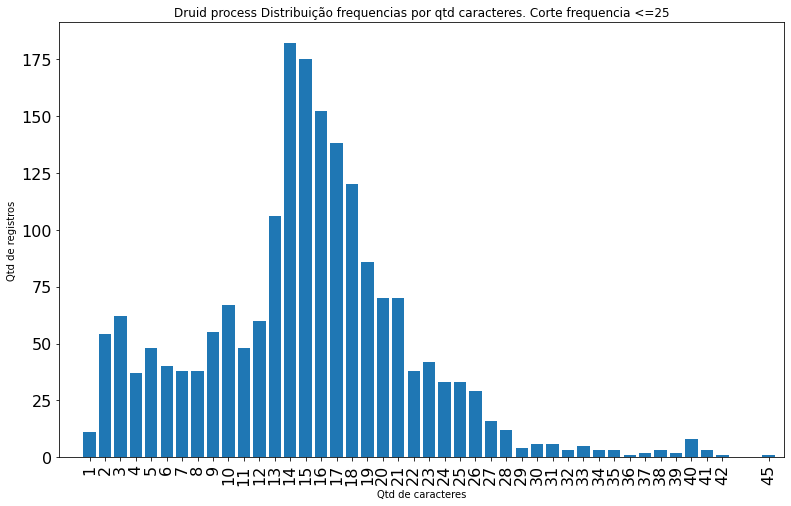

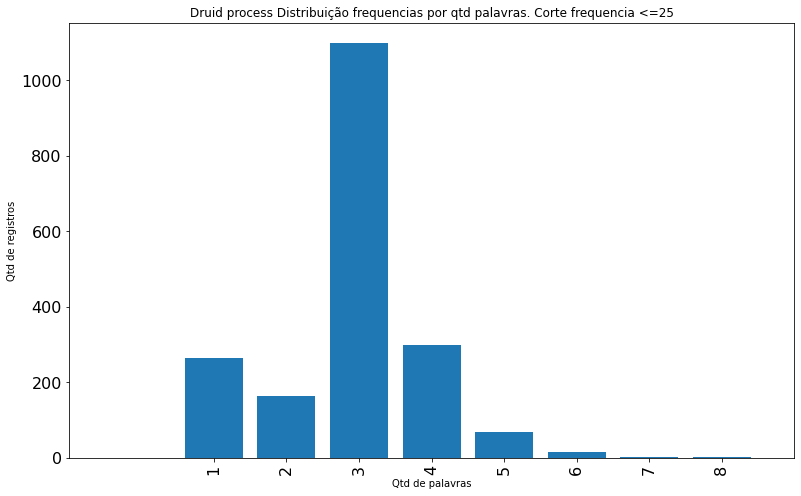

In [29]:
frequencia_desc_char = defaultdict(int)
frequencia_desc_str = defaultdict(int)
for key in frequencia_desc:
    if frequencia_desc[key] <= 25:
        desc_completa_char_len(frequencia_desc_char, key)
        desc_completa_str_len(frequencia_desc_str, key)

dist_freq_len(frequencia_desc_char, title+' Distribuição frequencias por qtd caracteres. Corte frequencia <=25', 'Qtd de caracteres')
dist_freq_len(frequencia_desc_str, title+' Distribuição frequencias por qtd palavras. Corte frequencia <=25', 'Qtd de palavras')

In [30]:
(6492 + 6744 - 6003)/9822

0.7364080635308491

In [31]:
def qtd_alpha(text):
    qtd = 0
    for char in text:
        if char.isalpha():
            qtd += 1
    return qtd

def checar_excluir(un_medida):
    exceptions = ['kg','km','kit','mes','par']
    if (qtd_alpha(un_medida) <= 3) and (un_medida not in exceptions):
        return True
    
    if (un_medida == None) or (len(un_medida.strip()) == 0):
        return True
    
    #if len(un_medida) > 10:
    #    return True
    
    #if len(un_medida.split(' ')) > 1:
    #    return True
    
    return False

 0.0 %
 2.7179097751799395 %
 5.435819550359879 %
 8.153729325539818 %
 10.871639100719758 %
 13.589548875899697 %
 16.307458651079635 %
 19.025368426259575 %
 21.743278201439516 %
 24.461187976619453 %
 27.179097751799393 %
 29.89700752697933 %
 32.61491730215927 %
 35.33282707733921 %
 38.05073685251915 %
 40.76864662769909 %
 43.48655640287903 %
 46.204466178058965 %
 48.922375953238905 %
 51.640285728418846 %
 54.358195503598786 %
 57.07610527877872 %
 59.79401505395866 %
 62.5119248291386 %
 65.22983460431854 %
 67.94774437949847 %
 70.66565415467842 %
 73.38356392985837 %
 76.1014737050383 %
 78.81938348021824 %
 81.53729325539818 %
 84.25520303057812 %
 86.97311280575806 %
 89.691022580938 %
 92.40893235611793 %
 95.12684213129788 %
 97.84475190647781 %
 media qtd palavras 1.0784174046244692
 media qtd caracteres 6.076812207111248
 quantidade unidade medida diferentes 2418
 quantidade registros excluidos 99793


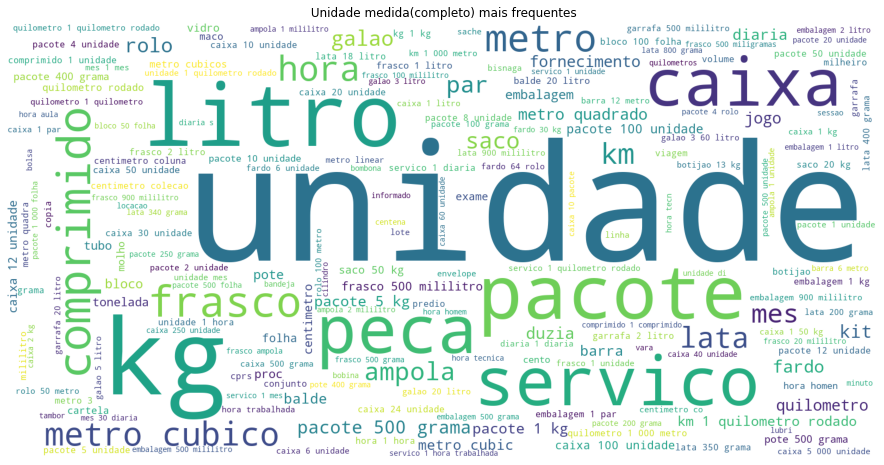

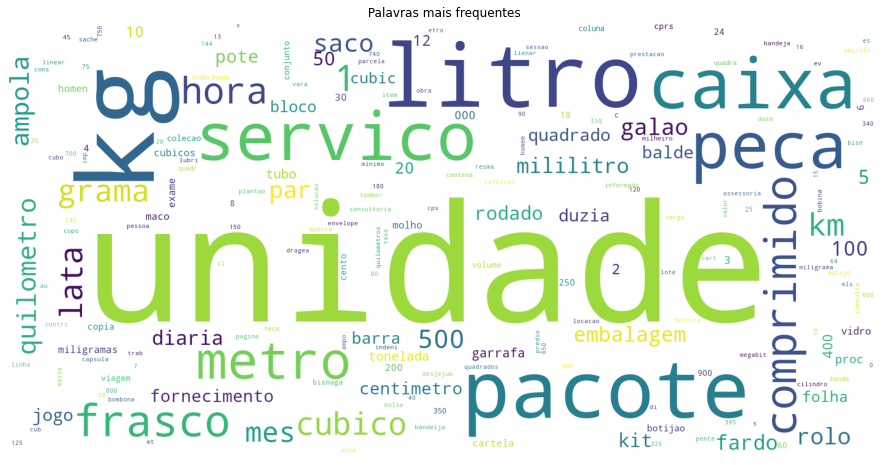

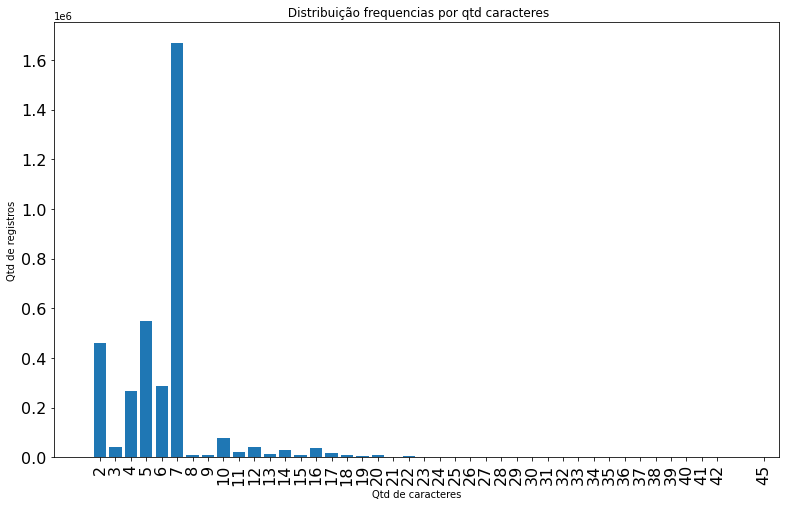

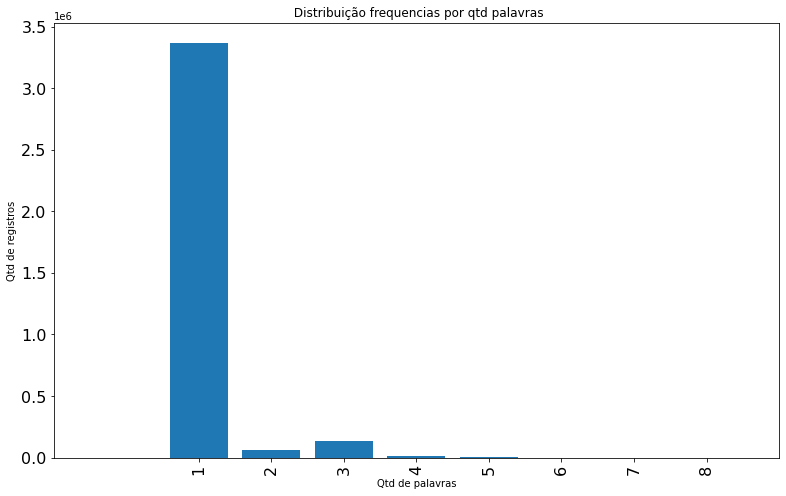

In [32]:
df=df_druid_process
title=''

#data_frames=[df_druid_process]
#titles=['Druid process']
#frequencia_desc = defaultdict(int)
unidade_medida_diferentes = []
unidade_medida_excluidos = []

frequencia_tokens = defaultdict(int)
frequencia_desc = defaultdict(int)
frequencia_desc_char = defaultdict(int)
frequencia_desc_str = defaultdict(int)



mean_qtd_palavras = 0
mean_qtd_char = 0

cont=0
size = df.shape[0]
for idx, values in df.iterrows():

    ##Exibir progresso
    if (cont % 100000) == 0:
        print(title, (cont/size)*100, '%')
    cont+=1
    ##


    un_medida = str(values['dsc_unidade_medida'])
    descricao = values['nom_item']

    if checar_excluir(un_medida):
        unidade_medida_excluidos.append(un_medida)
    else:
        unidade_medida_diferentes.append(un_medida)
        desc_completa_freq(frequencia_desc, un_medida)
        tokens_freq(frequencia_tokens, un_medida)
        desc_completa_char_len(frequencia_desc_char, un_medida)
        desc_completa_str_len(frequencia_desc_str, un_medida)
        mean_qtd_palavras += len(str(un_medida).split(' '))
        mean_qtd_char += len(str(un_medida))

    ##Terminar depois de uma amostra, para testar
    #if (cont == 300000):
    #    break
    
mean_qtd_palavras = mean_qtd_palavras/size
mean_qtd_char = mean_qtd_char/size
   
print(title, 'media qtd palavras', mean_qtd_palavras)
print(title, 'media qtd caracteres', mean_qtd_char)
print(title, 'quantidade unidade medida diferentes', len(np.unique(unidade_medida_diferentes)))
print(title, 'quantidade registros excluidos', len(unidade_medida_excluidos))
    

desc_word_cloud = word_cloud(frequencia_desc, title+' Unidade medida(completo) mais frequentes')
tokens_word_cloud = word_cloud(frequencia_tokens, title+' Palavras mais frequentes')

dist_freq_len(frequencia_desc_char, title+' Distribuição frequencias por qtd caracteres', 'Qtd de caracteres')
dist_freq_len(frequencia_desc_str, title+' Distribuição frequencias por qtd palavras', 'Qtd de palavras')

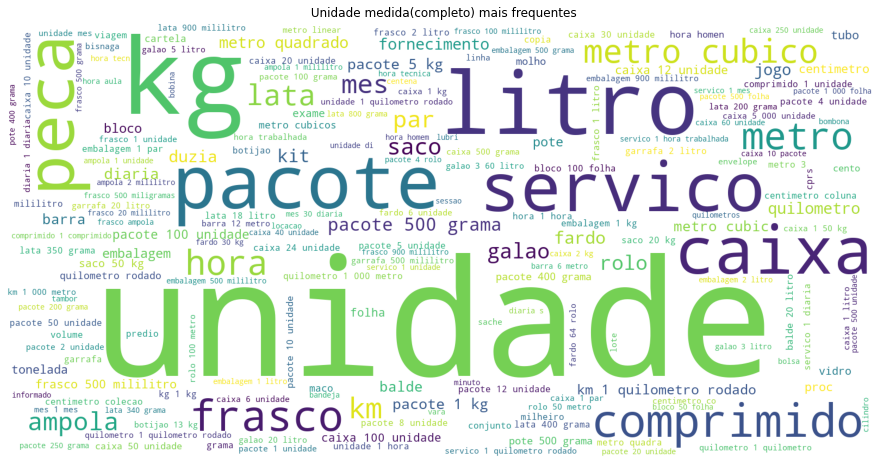

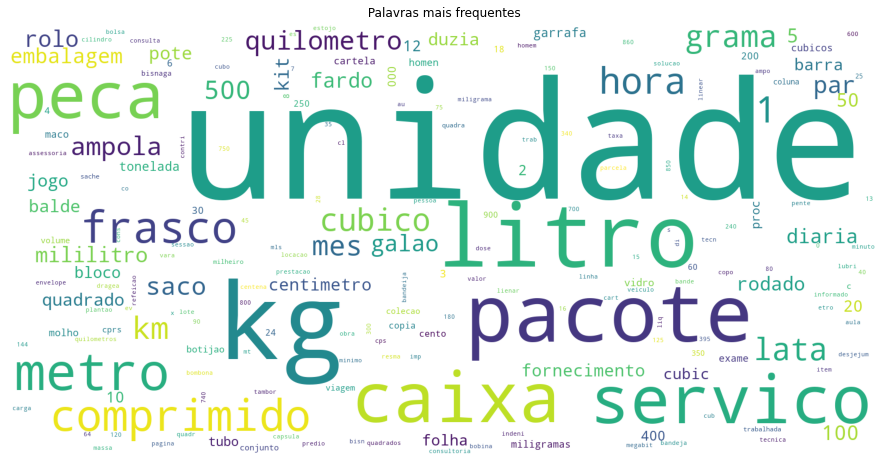

In [33]:
desc_word_cloud = word_cloud(frequencia_desc, title+' Unidade medida(completo) mais frequentes')
tokens_word_cloud = word_cloud(frequencia_tokens, title+' Palavras mais frequentes')

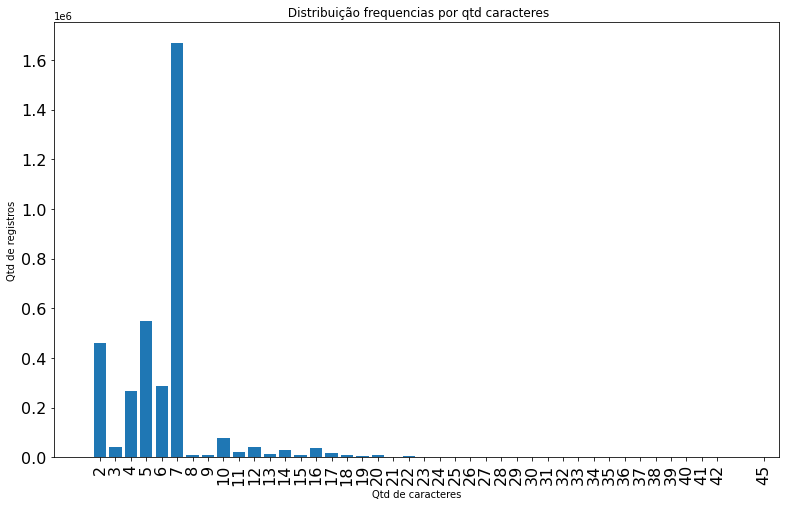

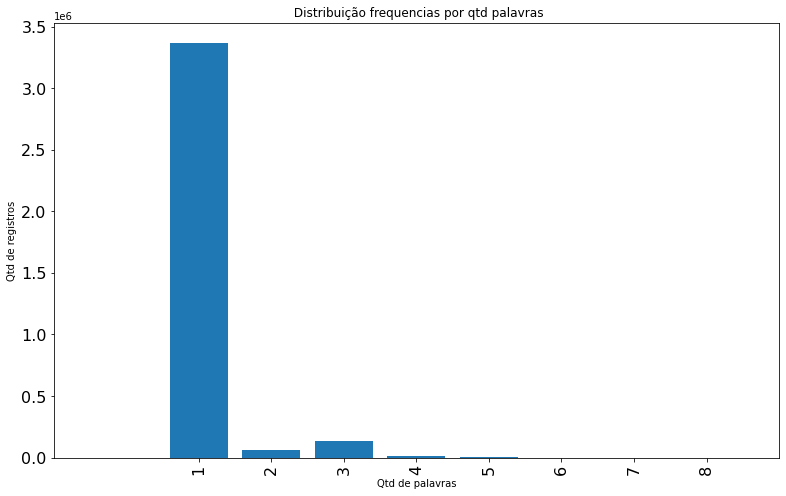

In [34]:
dist_freq_len(frequencia_desc_char, title+' Distribuição frequencias por qtd caracteres', 'Qtd de caracteres')
dist_freq_len(frequencia_desc_str, title+' Distribuição frequencias por qtd palavras', 'Qtd de palavras')

In [35]:
faixa1=0
faixa2=0
faixa3=0
faixa4=0
cont=0
print(len(frequencia_desc))
for key in frequencia_desc.keys():
    
    
    if frequencia_desc[key] <= 100:
        faixa1 += 1

    elif frequencia_desc[key] > 100 and frequencia_desc[key] <= 1000:
        faixa2 += 1

    elif frequencia_desc[key] > 1000 and frequencia_desc[key] <= 10000:
        faixa3 += 1

    elif frequencia_desc[key] > 10000:
        faixa4 += 1
        print(key)
        cont+=1                

faixa1,faixa2,faixa3,faixa4

2418
hora
litro
unidade
servico
kg
km
pacote
caixa
saco
metro cubico
lata
frasco
galao
peca
metro
par
rolo
ampola
comprimido
mes


(2087, 245, 66, 20)

In [36]:
df_arquivo_process.shape[0]

3679117

In [37]:
len(df_druid_process['dsc_unidade_medida_orig'].unique())

3286

In [38]:
un_unicas = np.unique(unidade_medida_diferentes)
for u in un_unicas:
    print(u)

000 metro cubico
01 lata 3 60 litro
01 lata 900 fardo
1 frasco 1 000 frasco litro
1 litro
10 frasco 4 mililitro
10 grama
10 litro
10 metro cubico
100 caixa
100 mililitro
12 hora 1 diaria
120 minuto
15 mililitro
2 litro
2 rolo
2 unidade
20 litro
200 mililitro
3 60 litro
3 metro cubico
30 grama
4 unidade
5 frasco 2 litro
5 litro
500 grama
700 grama
720 grama
abraca
adesivo
aerossol 200 dose
alcool
almotolia 100 mililitro
aluno
aluno mes
amost
amostra
ampo
ampol
ampola
ampola 0 25 mililitro
ampola 0 40 mililitro
ampola 1
ampola 1 50 miligramas
ampola 1 50 mililitro
ampola 1 ampola
ampola 1 grama
ampola 1 metro linear
ampola 1 miligrama
ampola 1 mililitro
ampola 1 milimetro
ampola 1 rolo
ampola 1 unidade
ampola 10
ampola 10 miligramas
ampola 10 mililitro
ampola 10 mls
ampola 100 miligramas
ampola 100 mililitro
ampola 11 25 ampola
ampola 2
ampola 2 50 mililitro
ampola 2 50 mls
ampola 2 miligrama 1 miligrama
ampola 2 miligramas
ampola 2 mililitro
ampola 2 mls
ampola 20 miligramas
ampola 20 m

In [39]:
len(un_unicas)

2418

In [40]:
token = 'tkl'
token = 'ucx'
token='slo'
print(df_druid_process[df_druid_process['dsc_unidade_medida']==token].shape[0])
df=df_druid_process[df_druid_process['dsc_unidade_medida']==token]
for idx,row in df.iterrows():
    print(row['nom_item'],row['dsc_unidade_medida'],row['dsc_unidade_medida_orig'])
#df[df['nom_item'].str.contains("OXIGENIO")]

0


In [41]:
un_unicas = np.unique(unidade_medida_excluidos)
for u in un_unicas:
    print(u)


0
0 00
0 80
01
01001
05
1
10
1000
11
12 mes
13
15
2
2 00
2 k
20
20 kg
20000
21
291 81
3
30
300
3000
3m2
4
4 00
420 75
494
50
60
7 25
78 65
9
9000
adv
am
ap
ass
aux
b
b20l
ba
bal
bal20
bd
bd 20
bdj
bem
bf
bg
bi
bis
bj
bl
bl 100
bl 300
bl100
bl50
bld
blt
bm
bn
bng
bot
br
bs
bsa
bu
c
c100
c3000
ca
cam
cax
cb
cd
ce
ch
chp
ci
cj
cjt
cl
clc
cld
cn
cnj
cnt
co
coj
cps
cr
crt
cs
ct
cto
d
dez
dg
di
dl
dm3
dr
dr 8
drg
ds
dz
eb
eb2l
ed
emb
emb 1
en
eng
et
ev
eve
f
fa
fam
far
fc
fd
fd 16 p
fis
fl
fr500g
ft
g200ml
ga
gel
gf
gfa
gl
gl 20 k
gl 3
gl1
gl5
gla
glb
grs
gt
h
h h
h tb
hh
ho
hs
ht
imp
ip
k
km r
kq
la
lav
lqd
lt18
lt3 6
lta
m2213 30
m4
ma
mbs
mc
md
mh
mho
mi
mlh
mli
mll
mln
mlo
mo
mr
ms
mt
mt2
mt3
mtl
mtq
mtr
n
nan
nl
nv
out
p
p c
p500g
pa
pac
pag
pc10
pc5
pct04
pct12
pd
pdc
pea
pes
pet
pg
pl
plc
pmd
pn
pnt
po
pot
pp
pr
pr a1
prs
ps
pte
qrt
r
rf
rk
rl
rmt
ro
rod
s
s or
sa
sas
sch
ser
sg
sh
sp
spe
spt
sr
srg
sv
sv d
sv p
svc
t
t 1 km
t km
ta
tb
tbo
tbp
tbr
tbs
tn
to
tp
tr
ts
ub
uc
ud
ui
vb
vd

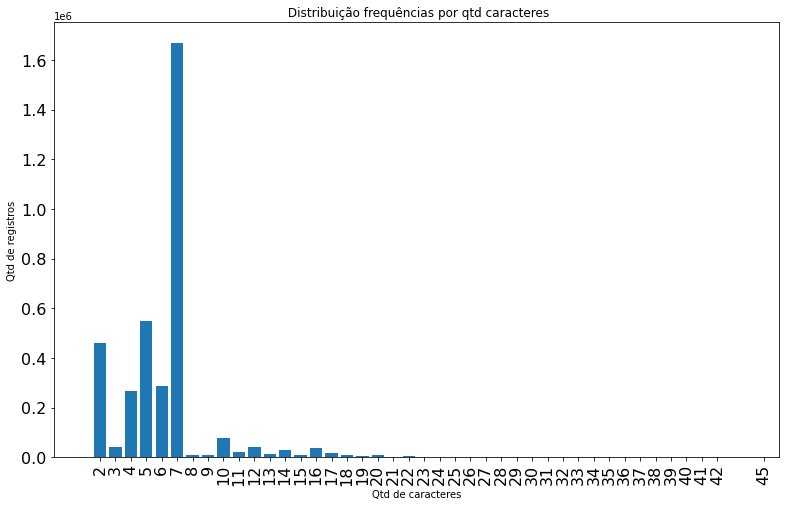

In [42]:
dist_freq_len(frequencia_desc_char, title+' Distribuição frequências por qtd caracteres', 'Qtd de caracteres')


In [43]:
df_cluester_result = pd.read_csv('../data/output/nota_fiscal_fasttext/cluster_prices_statistics.csv.zip', sep=';')
print('df_cluester_result', df_cluester_result.shape[0])
df_cluester_result.head()


df_cluester_result 96883


,grupo,dsc_unidade_medida,media,qtd,max,min,mediana,desvio_padrao,var,quantil_1,quantil_3,primeiro_termo,grupo_id,ruido
0,0000atm50,peca,3.000000,1,3.00,3.00,3.000,NaN,NaN,3.00,3.000,0000atm50,0,1
1,0e,peca,33.900000,1,33.90,33.90,33.900,NaN,NaN,33.90,33.900,0e,1,1
2,1,metro cubico,49.305000,4,94.71,3.90,49.305,52.429178,2748.818700,3.90,94.710,1,2,1
3,1,unidade,1.814444,18,5.75,0.31,0.775,1.729057,2.989638,0.65,2.875,1,3,1
4,10,frasco,2.450000,1,2.45,2.45,2.450,NaN,NaN,2.45,2.450,10,4,1


In [44]:
df_cluester_result['dsc_unidade_medida_pros'] = df_cluester_result.apply(lambda x : process_un_medida(x['dsc_unidade_medida']), axis=1)
df_cluester_result['dsc_unidade_medida_pros'] = df_cluester_result.apply(lambda x : '' if checar_excluir(x['dsc_unidade_medida_pros']) else x['dsc_unidade_medida_pros']  , axis=1)
df_cluester_result.head()

,grupo,dsc_unidade_medida,media,qtd,max,min,mediana,desvio_padrao,var,quantil_1,quantil_3,primeiro_termo,grupo_id,ruido,dsc_unidade_medida_pros
0,0000atm50,peca,3.000000,1,3.00,3.00,3.000,NaN,NaN,3.00,3.000,0000atm50,0,1,peca
1,0e,peca,33.900000,1,33.90,33.90,33.900,NaN,NaN,33.90,33.900,0e,1,1,peca
2,1,metro cubico,49.305000,4,94.71,3.90,49.305,52.429178,2748.818700,3.90,94.710,1,2,1,metro cubico
3,1,unidade,1.814444,18,5.75,0.31,0.775,1.729057,2.989638,0.65,2.875,1,3,1,unidade
4,10,frasco,2.450000,1,2.45,2.45,2.450,NaN,NaN,2.45,2.450,10,4,1,frasco


In [45]:
qtd_grupos=df_cluester_result.groupby(by=["grupo"]).count().shape[0]
qtd_grupos_un_medida=df_cluester_result.groupby(by=["grupo", "dsc_unidade_medida"]).count().shape[0]

df=df_cluester_result[df_cluester_result["dsc_unidade_medida_pros"] != '']
qtd_grupos_un_medida_pros = df.groupby(by=["grupo", "dsc_unidade_medida_pros"]).count().shape[0]

qtd_25_mais = df_cluester_result[df_cluester_result["qtd"]>=25].shape[0]

df=df_cluester_result[df_cluester_result["dsc_unidade_medida_pros"] != '']
df=df.groupby(by=["grupo", "dsc_unidade_medida_pros"]).sum()
qtd_25_mais_pros = df[df["qtd"]>=25].shape[0]

df=df_cluester_result.groupby(by=["grupo", "dsc_unidade_medida"]).sum()
qts_itens_grupos_25_mais = df[df["qtd"]>=25]["qtd"].sum()

df=df_cluester_result[df_cluester_result["dsc_unidade_medida_pros"] != '']
df=df.groupby(by=["grupo", "dsc_unidade_medida_pros"]).sum()
qts_itens_grupos_25_mais_pros = df[df["qtd"]>=25]["qtd"].sum()

qtd_itens=df_cluester_result["qtd"].sum()

df=df_cluester_result[df_cluester_result["dsc_unidade_medida_pros"] != '']
qtd_itens_pros=df["qtd"].sum()


print('qtd_grupos', qtd_grupos)
print('qtd_grupos_un_medida', qtd_grupos_un_medida)
print('qtd_grupos_un_medida_pros', qtd_grupos_un_medida_pros)
print('qtd_25_mais', qtd_25_mais)
print('qtd_25_mais_pros', qtd_25_mais_pros)
print('qts_itens_grupos_25_mais', qts_itens_grupos_25_mais)
print('qts_itens_grupos_25_mais_pros', qts_itens_grupos_25_mais_pros)
print('qtd_itens', qtd_itens)
print('qtd_itens_pros', qtd_itens_pros)


qtd_grupos 37139
qtd_grupos_un_medida 96882
qtd_grupos_un_medida_pros 90773
qtd_25_mais 22424
qtd_25_mais_pros 21783
qts_itens_grupos_25_mais 2441080
qts_itens_grupos_25_mais_pros 2390234
qtd_itens 2845780
qtd_itens_pros 2771199


In [46]:
df_items_result = pd.read_csv('../data/output/druid/items_clusters_train.csv.zip', sep=';')
print('df_cluester_result', df_items_result.shape[0])
df_items_result.head()

df_cluester_result 10560288


,item_id,seq_dim_licitacao,outlier,cluster,dsc_unidade_medida,ano,description,original,areas,price,first_token
0,171782,242872,1,fosa,unidade,2014,fosa septico alvenaria tijolo ceramico macico ...,FOSA SEPTICA EM ALVENARIA DE TIJOLO CERAMICO M...,NaN,1021.87,fosa
1,64082,189529,1,carlota_-1,unidade,2014,carlota lote5,LOTE5-CARLOTA,NaN,25.00,carlota
2,121806,189529,1,carlota_-1,unidade,2014,carlota lote7,LOTE7-CARLOTA,NaN,25.00,carlota
3,189177,189550,1,carlota_-1,unidade,2014,carlota lote6,LOTE6-CARLOTA,NaN,30.00,carlota
4,208588,189529,1,carlota_-1,unidade,2014,carlota lote6,LOTE6-CARLOTA,NaN,25.00,carlota


In [47]:
df_items_result['dsc_unidade_medida_pros'] = df_items_result.apply(lambda x : process_un_medida(x['dsc_unidade_medida']), axis=1)
df_items_result['dsc_unidade_medida_pros'] = df_items_result.apply(lambda x : '' if checar_excluir(x['dsc_unidade_medida_pros']) else x['dsc_unidade_medida_pros']  , axis=1)
df_items_result.head()

,item_id,seq_dim_licitacao,outlier,cluster,dsc_unidade_medida,ano,description,original,areas,price,first_token,dsc_unidade_medida_pros
0,171782,242872,1,fosa,unidade,2014,fosa septico alvenaria tijolo ceramico macico ...,FOSA SEPTICA EM ALVENARIA DE TIJOLO CERAMICO M...,NaN,1021.87,fosa,unidade
1,64082,189529,1,carlota_-1,unidade,2014,carlota lote5,LOTE5-CARLOTA,NaN,25.00,carlota,unidade
2,121806,189529,1,carlota_-1,unidade,2014,carlota lote7,LOTE7-CARLOTA,NaN,25.00,carlota,unidade
3,189177,189550,1,carlota_-1,unidade,2014,carlota lote6,LOTE6-CARLOTA,NaN,30.00,carlota,unidade
4,208588,189529,1,carlota_-1,unidade,2014,carlota lote6,LOTE6-CARLOTA,NaN,25.00,carlota,unidade


In [48]:
qtd_grupos=df_items_result.groupby(by=["cluster"]).count().shape[0]
qtd_grupos_un_medida=df_items_result.groupby(by=["cluster", "dsc_unidade_medida"]).count().shape[0]

df=df_items_result[df_items_result["dsc_unidade_medida_pros"] != '']
qtd_grupos_un_medida_pros = df.groupby(by=["cluster", "dsc_unidade_medida_pros"]).count().shape[0]

df=df_items_result.groupby(by=["cluster", "dsc_unidade_medida"]).count()
qtd_25_mais = df[df["item_id"]>=25].shape[0]

df=df_items_result[df_items_result["dsc_unidade_medida_pros"] != '']
df=df.groupby(by=["cluster", "dsc_unidade_medida_pros"]).count()
qtd_25_mais_pros = df[df["item_id"]>=25].shape[0]

df=df_items_result.groupby(by=["cluster", "dsc_unidade_medida"]).count()
qts_itens_grupos_25_mais = df[df["item_id"]>=25]["item_id"].sum()

df=df_items_result[df_items_result["dsc_unidade_medida_pros"] != '']
df=df.groupby(by=["cluster", "dsc_unidade_medida_pros"]).count()
qts_itens_grupos_25_mais_pros = df[df["item_id"]>=25]["item_id"].sum()

qtd_itens=df_items_result.shape[0]

df=df_items_result[df_items_result["dsc_unidade_medida_pros"] != '']
qtd_itens_pros=df.shape[0]


print('qtd_grupos', qtd_grupos)
print('qtd_grupos_un_medida', qtd_grupos_un_medida)
print('qtd_grupos_un_medida_pros', qtd_grupos_un_medida_pros)
print('qtd_25_mais', qtd_25_mais)
print('qtd_25_mais_pros', qtd_25_mais_pros)
print('qts_itens_grupos_25_mais', qts_itens_grupos_25_mais)
print('qts_itens_grupos_25_mais_pros', qts_itens_grupos_25_mais_pros)
print('qtd_itens', qtd_itens)
print('qtd_itens_pros', qtd_itens_pros)

qtd_grupos 78662
qtd_grupos_un_medida 320291
qtd_grupos_un_medida_pros 283213
qtd_25_mais 58981
qtd_25_mais_pros 57545
qts_itens_grupos_25_mais 9307786
qts_itens_grupos_25_mais_pros 9203392
qtd_itens 10560288
qtd_itens_pros 10300794


In [49]:
df_items_wo_out_result = pd.read_csv('../data/output/nota_fiscal_fasttext/items_clusters_train_wo_out.csv.zip', sep=';')
print('df_cluester_result', df_items_wo_out_result.shape[0])
df_items_wo_out_result.head()

df_cluester_result 2845780


,grupo,dsc_unidade_medida,grupo_id,item_id,grupo_ruido,item_ruido,preco,original,ano,licitacao,licitacao_item,original_dsc,primeiro_termo
0,0000atm50,peca,0,1850682,1,1,3.00,00K0000ATM50 FUSIVEL 307721,2017,101326386,40992041,k 0000atm50 fusivel 00,0000atm50
1,0e,peca,1,451719,1,1,33.90,15208 65F0E FILTRO DE LEO,2014,90918713,38513943,f 0e filtro leo 65,0e
2,1,metro cubico,2,3381124,1,1,94.71,14 1 COM CANGA DE MINERIO DE FERRO BASE ESTAB ...,2020,122006410,44994340,1 com canga minerio ferro base estab granel co...,1
3,1,metro cubico,2,3381130,1,1,3.90,4 1 COM ROLO VIBRATORIO ATERRO COMPACTADO,2020,122006410,44994343,1 com rolo vibratorio aterro compactar 4,1
4,1,metro cubico,2,3382343,1,1,3.90,4 1 COM ROLO VIBRATORIO ATERRO COMPACTADO,2020,121801715,44940185,1 com rolo vibratorio aterro compactar 4,1


In [50]:
df_cluester_result['count'].sum(), df_items_result.shape[0],df_items_wo_out_result.shape[0]

KeyError: 'count'

In [ ]:
df_cluester_result.groupby(by=["cluster", "dsc_unidade_medida"]).count().shape[0],df_items_result.groupby(by=["cluster", "dsc_unidade_medida"]).count().shape[0],df_items_wo_out_result.groupby(by=["cluster", "dsc_unidade_medida"]).count().shape[0]

In [ ]:
df = pd.read_csv('../data/base_druid/items_preprocessed_complete_druid.csv.zip', sep=';')
df.head()
